In [1]:
# Install required packages.
import os

# !pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


1.12.1+cpu


In [2]:
# pip install deepchem==2.6.1

In [3]:
import torch
import pandas as pd
import numpy as np
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.data import Dataset
import numpy as np 
import os
import deepchem as dc
import torch.nn as nn
from torch.nn import Linear,BatchNorm1d
from torch_geometric.nn import GCNConv,GATv2Conv
from torch_geometric.nn import BatchNorm
from tqdm import tqdm
from torch_geometric.data import DataLoader
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
import seaborn as sns
import pandas as pd 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import math
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('raw/totalData.csv')
data.head()

,Unnamed: 0,Drug1_ID,Drug1_SMILES
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1
1,1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl
2,2,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...
3,3,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1
4,4,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12


In [5]:
len(data)

10951

# Molecular Graph from SMILES

In [6]:
remove = []

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.sz = 0
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        count = 0
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            if type(mol["Drug1_SMILES"])==float:
              remove.append(mol["Drug1_ID"])
              continue
            f = featurizer.featurize(mol["Drug1_SMILES"])
            if not f : 
              remove.append(mol["Drug1_ID"])
              print(count)
              continue
            data = f[0].to_pyg_graph()
            data.y = 1
            data.smiles = mol["Drug1_SMILES"]
            data.id = mol["Drug1_ID"]
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_test_{count}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_{count}.pt'))
            count+=1
        self.sz = count

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.sz
        #return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data

encoder_set = MoleculeDataset("","totalData.csv")

Processing...
  1%|▍                                                                              | 67/10951 [00:03<07:47, 23.30it/s]Failed to featurize datapoint 0, [Mg+2].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  1%|▌                                                                              | 73/10951 [00:03<07:35, 23.88it/s]

68


  1%|▌                                                                              | 76/10951 [00:03<07:39, 23.64it/s]Failed to featurize datapoint 0, [Gd+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  1%|▌                                                                              | 82/10951 [00:03<07:46, 23.30it/s]

76


  1%|█                                                                             | 151/10951 [00:07<06:56, 25.92it/s]Failed to featurize datapoint 0, [81Kr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


149


  1%|█▏                                                                            | 164/10951 [00:07<07:34, 23.75it/s]Failed to featurize datapoint 0, [Li+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  2%|█▏                                                                            | 172/10951 [00:08<06:34, 27.32it/s]

163


  3%|██▌                                                                           | 353/10951 [00:17<07:07, 24.81it/s]Failed to featurize datapoint 0, [Al+3].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  3%|██▌                                                                           | 357/10951 [00:17<06:10, 28.59it/s]

349


  4%|███                                                                           | 424/10951 [00:20<06:57, 25.20it/s]Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  4%|███                                                                           | 430/10951 [00:20<07:29, 23.38it/s]

420


  4%|███                                                                           | 433/10951 [00:20<07:11, 24.37it/s]Failed to featurize datapoint 0, [Sb+5]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  4%|███                                                                           | 436/10951 [00:21<07:24, 23.65it/s]

427


  5%|███▌                                                                          | 497/10951 [00:23<07:32, 23.11it/s]Failed to featurize datapoint 0, [Cr+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  5%|███▌                                                                          | 504/10951 [00:23<06:42, 25.94it/s]

491


  5%|████▎                                                                         | 598/10951 [00:28<06:49, 25.27it/s]Failed to featurize datapoint 0, [Fe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  5%|████▎                                                                         | 602/10951 [00:28<06:16, 27.52it/s]

590


  6%|████▌                                                                         | 637/10951 [00:29<08:09, 21.07it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Mg+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  6%|████▌                                                                         | 643/10951 [00:29<07:24, 23.19it/s]

629


  8%|██████▌                                                                       | 920/10951 [00:43<09:56, 16.82it/s]Failed to featurize datapoint 0, [Mg+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  8%|██████▌                                                                       | 923/10951 [00:44<11:02, 15.14it/s]

911


  9%|██████▋                                                                       | 943/10951 [00:44<07:16, 22.90it/s]Failed to featurize datapoint 0, [13NH3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  9%|██████▊                                                                       | 950/10951 [00:45<06:46, 24.63it/s]

934


  9%|███████▏                                                                     | 1020/10951 [00:48<07:41, 21.51it/s]Failed to featurize datapoint 0, [Zn+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  9%|███████▏                                                                     | 1024/10951 [00:48<06:50, 24.20it/s]

1008


 11%|████████▌                                                                    | 1217/10951 [00:57<07:12, 22.48it/s]Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 11%|████████▌                                                                    | 1221/10951 [00:57<06:25, 25.27it/s]

1205


 11%|████████▋                                                                    | 1236/10951 [00:58<07:33, 21.44it/s]Failed to featurize datapoint 0, [131I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 11%|████████▋                                                                    | 1243/10951 [00:58<07:10, 22.54it/s]

1224


 12%|█████████                                                                    | 1286/10951 [01:00<07:14, 22.23it/s]Failed to featurize datapoint 0, [Cl-].[NH4+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 12%|█████████                                                                    | 1289/10951 [01:01<07:01, 22.92it/s]

1271


 12%|█████████▎                                                                   | 1320/10951 [01:02<07:04, 22.70it/s]Failed to featurize datapoint 0, [89Sr+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 12%|█████████▎                                                                   | 1324/10951 [01:02<06:26, 24.88it/s]

1304


 14%|██████████▊                                                                  | 1535/10951 [01:12<06:32, 24.01it/s]Failed to featurize datapoint 0, [3He]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 14%|██████████▊                                                                  | 1538/10951 [01:12<06:43, 23.34it/s]

1518


 14%|██████████▉                                                                  | 1562/10951 [01:13<06:19, 24.72it/s]Failed to featurize datapoint 0, [Cl-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 14%|███████████                                                                  | 1566/10951 [01:14<05:42, 27.38it/s]

1545


 14%|███████████                                                                  | 1573/10951 [01:14<05:57, 26.20it/s]Failed to featurize datapoint 0, [La+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [Zn]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 14%|███████████                                                                  | 1578/10951 [01:14<05:14, 29.83it/s]

1554
1554


 15%|███████████▊                                                                 | 1675/10951 [01:21<09:55, 15.58it/s]Failed to featurize datapoint 0, [Co]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 15%|███████████▊                                                                 | 1681/10951 [01:21<08:06, 19.06it/s]

1656


 17%|████████████▊                                                                | 1831/10951 [01:28<06:34, 23.09it/s]Failed to featurize datapoint 0, O.O.O.O.[98Tc-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 17%|████████████▉                                                                | 1837/10951 [01:28<07:38, 19.88it/s]

1811


 18%|█████████████▌                                                               | 1935/10951 [01:33<08:32, 17.59it/s]Failed to featurize datapoint 0, [Na+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 18%|█████████████▋                                                               | 1938/10951 [01:33<07:48, 19.25it/s]

1913


 18%|█████████████▊                                                               | 1965/10951 [01:34<06:12, 24.15it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Sn+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 18%|█████████████▊                                                               | 1971/10951 [01:35<06:36, 22.67it/s]

1942


 18%|█████████████▉                                                               | 1986/10951 [01:35<06:43, 22.22it/s]Failed to featurize datapoint 0, [Mg+2].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 18%|█████████████▉                                                               | 1989/10951 [01:36<07:04, 21.13it/s]

1961


 20%|███████████████                                                              | 2140/10951 [01:42<06:57, 21.10it/s]Failed to featurize datapoint 0, O. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 20%|███████████████                                                              | 2147/10951 [01:43<05:42, 25.69it/s]

2116


 24%|██████████████████▊                                                          | 2670/10951 [02:06<05:58, 23.10it/s]Failed to featurize datapoint 0, [89Sr+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 24%|██████████████████▊                                                          | 2674/10951 [02:06<05:14, 26.35it/s]

2643


 26%|███████████████████▊                                                         | 2815/10951 [02:13<06:00, 22.59it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Zn+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 26%|███████████████████▊                                                         | 2819/10951 [02:13<05:11, 26.11it/s]

2788


 26%|███████████████████▊                                                         | 2822/10951 [02:13<05:27, 24.85it/s]Failed to featurize datapoint 0, [Pt]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|███████████████████▉                                                         | 2829/10951 [02:13<05:25, 24.97it/s]

2795


 26%|███████████████████▉                                                         | 2841/10951 [02:14<05:32, 24.39it/s]Failed to featurize datapoint 0, [223Ra+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|████████████████████                                                         | 2845/10951 [02:14<05:10, 26.10it/s]Failed to featurize datapoint 0, [67Ga+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


2811
2815


 26%|████████████████████▏                                                        | 2879/10951 [02:15<06:13, 21.64it/s]Failed to featurize datapoint 0, [Ne]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|████████████████████▎                                                        | 2883/10951 [02:15<05:38, 23.84it/s]

2848


 29%|██████████████████████                                                       | 3144/10951 [02:27<05:16, 24.71it/s]Failed to featurize datapoint 0, [32PH3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 29%|██████████████████████▏                                                      | 3148/10951 [02:27<04:49, 26.97it/s]

3111


 29%|██████████████████████▏                                                      | 3161/10951 [02:28<04:39, 27.87it/s]Failed to featurize datapoint 0, [K+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 29%|██████████████████████▎                                                      | 3165/10951 [02:28<04:21, 29.78it/s]

3128


 30%|██████████████████████▊                                                      | 3246/10951 [02:31<04:51, 26.40it/s]Failed to featurize datapoint 0, [Ac]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|██████████████████████▊                                                      | 3250/10951 [02:31<04:27, 28.78it/s]

3212


 30%|██████████████████████▉                                                      | 3256/10951 [02:32<04:56, 25.98it/s]Failed to featurize datapoint 0, F. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|██████████████████████▉                                                      | 3262/10951 [02:32<04:54, 26.07it/s]

3222


 30%|███████████████████████▏                                                     | 3292/10951 [02:33<06:06, 20.90it/s]Failed to featurize datapoint 0, [Al+3].[Al+3].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 30%|███████████████████████▏                                                     | 3297/10951 [02:34<06:33, 19.46it/s]

3258


 30%|███████████████████████▎                                                     | 3319/10951 [02:35<05:15, 24.18it/s]Failed to featurize datapoint 0, [Cl-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|███████████████████████▍                                                     | 3327/10951 [02:35<04:37, 27.47it/s]

3283


 32%|████████████████████████▍                                                    | 3482/10951 [02:42<05:18, 23.46it/s]Failed to featurize datapoint 0, [Ag+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 32%|████████████████████████▌                                                    | 3488/10951 [02:42<05:18, 23.44it/s]

3444


 33%|█████████████████████████▏                                                   | 3585/10951 [02:47<05:13, 23.51it/s]Failed to featurize datapoint 0, [Ca+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 33%|█████████████████████████▎                                                   | 3592/10951 [02:47<04:47, 25.62it/s]

3546


 33%|█████████████████████████▎                                                   | 3604/10951 [02:48<05:33, 22.00it/s]Failed to featurize datapoint 0, [Cl-].[NH4+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 33%|█████████████████████████▍                                                   | 3609/10951 [02:48<04:35, 26.69it/s]

3563


 34%|██████████████████████████▌                                                  | 3773/10951 [02:56<05:17, 22.59it/s]Failed to featurize datapoint 0, [Al+3].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 35%|██████████████████████████▌                                                  | 3781/10951 [02:56<04:37, 25.84it/s]

3733


 35%|██████████████████████████▌                                                  | 3784/10951 [02:57<04:46, 25.01it/s]Failed to featurize datapoint 0, [Ca+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 35%|██████████████████████████▋                                                  | 3788/10951 [02:57<04:15, 28.06it/s]

3741


 35%|██████████████████████████▉                                                  | 3831/10951 [02:59<04:52, 24.32it/s]Failed to featurize datapoint 0, [Ta]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 35%|██████████████████████████▉                                                  | 3835/10951 [02:59<04:31, 26.24it/s]

3787


 35%|███████████████████████████                                                  | 3847/10951 [02:59<04:33, 25.97it/s]Failed to featurize datapoint 0, [Bk]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 35%|███████████████████████████                                                  | 3850/10951 [02:59<04:23, 26.92it/s]

3802


 36%|████████████████████████████                                                 | 3983/10951 [03:05<05:47, 20.08it/s]Failed to featurize datapoint 0, [Li+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 36%|████████████████████████████                                                 | 3991/10951 [03:06<04:33, 25.47it/s]

3940


 37%|████████████████████████████▍                                                | 4045/10951 [03:09<14:15,  8.07it/s]Failed to featurize datapoint 0, [Ti]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 37%|████████████████████████████▍                                                | 4052/10951 [03:09<08:25, 13.65it/s]

4000


 37%|████████████████████████████▌                                                | 4061/10951 [03:10<06:44, 17.03it/s]Failed to featurize datapoint 0, [Co+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 37%|████████████████████████████▌                                                | 4069/10951 [03:10<05:35, 20.53it/s]

4015


 38%|█████████████████████████████▏                                               | 4156/10951 [03:14<04:54, 23.06it/s]Failed to featurize datapoint 0, [Fe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 38%|█████████████████████████████▎                                               | 4162/10951 [03:14<04:56, 22.91it/s]

4108


 38%|█████████████████████████████▍                                               | 4188/10951 [03:16<05:19, 21.15it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Cl-].[Cr+3]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 38%|█████████████████████████████▍                                               | 4195/10951 [03:16<04:31, 24.86it/s]

4138


 39%|█████████████████████████████▋                                               | 4226/10951 [03:17<05:24, 20.74it/s][16:51:05] Conflicting single bond directions around double bond at index 1.
[16:51:05]   BondStereo set to STEREONONE and single bond directions set to NONE.
 39%|█████████████████████████████▉                                               | 4257/10951 [03:19<04:23, 25.39it/s]Failed to featurize datapoint 0, [99Tc]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 39%|█████████████████████████████▉                                               | 4261/10951 [03:19<04:07, 27.01it/s]

4206


 41%|███████████████████████████████▎                                             | 4447/10951 [03:28<05:29, 19.75it/s]Failed to featurize datapoint 0, [131I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 41%|███████████████████████████████▎                                             | 4451/10951 [03:28<04:55, 21.96it/s]

4395


 41%|███████████████████████████████▋                                             | 4505/10951 [03:31<04:46, 22.48it/s]Failed to featurize datapoint 0, [Ba]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [Mo]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 41%|███████████████████████████████▋                                             | 4509/10951 [03:31<04:06, 26.17it/s]

4452
4453


 43%|█████████████████████████████████▎                                           | 4730/10951 [03:41<04:25, 23.43it/s]Failed to featurize datapoint 0, [Cd]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 43%|█████████████████████████████████▎                                           | 4734/10951 [03:41<03:56, 26.28it/s]

4676


 43%|█████████████████████████████████▍                                           | 4759/10951 [03:43<04:39, 22.12it/s]Failed to featurize datapoint 0, [123I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 43%|█████████████████████████████████▍                                           | 4762/10951 [03:43<04:52, 21.15it/s]

4703


 45%|██████████████████████████████████▊                                          | 4956/10951 [03:52<04:46, 20.94it/s]Failed to featurize datapoint 0, [P]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 45%|██████████████████████████████████▉                                          | 4961/10951 [03:52<04:07, 24.24it/s]

4899


 46%|███████████████████████████████████▎                                         | 5020/10951 [03:55<04:42, 21.02it/s]Failed to featurize datapoint 0, [Li+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 46%|███████████████████████████████████▎                                         | 5023/10951 [03:55<04:30, 21.92it/s]

4962


 46%|███████████████████████████████████▌                                         | 5052/10951 [03:56<05:18, 18.52it/s]Failed to featurize datapoint 0, [OH-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 46%|███████████████████████████████████▌                                         | 5056/10951 [03:57<04:33, 21.58it/s]

4994


 47%|████████████████████████████████████▌                                        | 5201/10951 [04:03<04:09, 23.09it/s]Failed to featurize datapoint 0, [Se]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 48%|████████████████████████████████████▌                                        | 5208/10951 [04:03<04:04, 23.52it/s]

5143


 48%|████████████████████████████████████▉                                        | 5261/10951 [04:06<04:08, 22.90it/s]Failed to featurize datapoint 0, [I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 48%|█████████████████████████████████████                                        | 5265/10951 [04:06<03:49, 24.73it/s]

5201


 49%|█████████████████████████████████████▋                                       | 5356/10951 [04:10<04:23, 21.21it/s]Failed to featurize datapoint 0, [Cl-].[Tl+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 49%|█████████████████████████████████████▋                                       | 5362/10951 [04:10<04:30, 20.68it/s]

5296


 49%|█████████████████████████████████████▊                                       | 5373/10951 [04:11<03:39, 25.44it/s]Failed to featurize datapoint 0, [18F]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 49%|█████████████████████████████████████▊                                       | 5380/10951 [04:11<03:17, 28.21it/s]

5312


 50%|██████████████████████████████████████▎                                      | 5447/10951 [04:14<03:53, 23.56it/s]Failed to featurize datapoint 0, [V]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 50%|██████████████████████████████████████▎                                      | 5454/10951 [04:14<03:38, 25.14it/s]

5385


 50%|██████████████████████████████████████▍                                      | 5470/10951 [04:15<04:19, 21.10it/s]Failed to featurize datapoint 0, [82Rb+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 50%|██████████████████████████████████████▍                                      | 5473/10951 [04:15<04:13, 21.62it/s]

5406


 51%|███████████████████████████████████████                                      | 5553/10951 [04:19<03:43, 24.19it/s]Failed to featurize datapoint 0, [Cl-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 51%|███████████████████████████████████████                                      | 5557/10951 [04:19<03:17, 27.35it/s]Failed to featurize datapoint 0, [51Cr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


5487
5491


 51%|███████████████████████████████████████▎                                     | 5592/10951 [04:20<04:01, 22.21it/s]Failed to featurize datapoint 0, [Sb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|███████████████████████████████████████▍                                     | 5600/10951 [04:21<03:17, 27.09it/s]

5526


Failed to featurize datapoint 0, [177Lu]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|███████████████████████████████████████▍                                     | 5607/10951 [04:21<03:03, 29.06it/s]

5533


 52%|███████████████████████████████████████▉                                     | 5674/10951 [04:24<04:27, 19.72it/s]Failed to featurize datapoint 0, [C]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 52%|███████████████████████████████████████▉                                     | 5678/10951 [04:24<04:10, 21.02it/s]

5604


 52%|████████████████████████████████████████▏                                    | 5709/10951 [04:25<03:25, 25.48it/s]Failed to featurize datapoint 0, [Rb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 52%|████████████████████████████████████████▏                                    | 5716/10951 [04:25<03:06, 28.14it/s]

5640


 53%|████████████████████████████████████████▊                                    | 5800/10951 [04:29<03:14, 26.46it/s]Failed to featurize datapoint 0, [Zn]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 53%|████████████████████████████████████████▊                                    | 5807/10951 [04:29<03:07, 27.51it/s]

5729


 56%|███████████████████████████████████████████▍                                 | 6183/10951 [04:52<03:20, 23.77it/s]Failed to featurize datapoint 0, [Fe+3].[O-2].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 57%|███████████████████████████████████████████▌                                 | 6190/10951 [04:52<02:59, 26.49it/s]

6112


 59%|█████████████████████████████████████████████▋                               | 6494/10951 [05:11<03:10, 23.36it/s]Failed to featurize datapoint 0, [90Y]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 59%|█████████████████████████████████████████████▋                               | 6500/10951 [05:11<03:04, 24.10it/s]

6422


 60%|██████████████████████████████████████████████                               | 6553/10951 [05:14<03:41, 19.82it/s]Failed to featurize datapoint 0, O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.[Mo].[Mo].[Mo].[Mo].[Mo].[Mo].[Mo].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 60%|██████████████████████████████████████████████                               | 6557/10951 [05:14<03:18, 22.11it/s]

6479


 60%|██████████████████████████████████████████████▎                              | 6578/10951 [05:15<03:47, 19.22it/s]Failed to featurize datapoint 0, [153Sm]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 60%|██████████████████████████████████████████████▎                              | 6582/10951 [05:15<03:16, 22.25it/s]

6502


 62%|███████████████████████████████████████████████▋                             | 6784/10951 [05:26<02:47, 24.94it/s]Failed to featurize datapoint 0, [Cr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 62%|███████████████████████████████████████████████▋                             | 6787/10951 [05:26<02:47, 24.81it/s]

6707


 62%|███████████████████████████████████████████████▊                             | 6793/10951 [05:27<03:09, 21.88it/s]Failed to featurize datapoint 0, [Na+].[Na+].[S-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 62%|███████████████████████████████████████████████▊                             | 6800/10951 [05:27<02:38, 26.15it/s]

6717


 63%|████████████████████████████████████████████████▏                            | 6855/10951 [05:29<03:03, 22.34it/s]Failed to featurize datapoint 0, [201Tl+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 63%|████████████████████████████████████████████████▏                            | 6858/10951 [05:29<02:58, 22.98it/s]

6776


 65%|██████████████████████████████████████████████████▏                          | 7129/10951 [05:42<03:41, 17.22it/s]Failed to featurize datapoint 0, [B]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 65%|██████████████████████████████████████████████████▏                          | 7134/10951 [05:42<02:49, 22.50it/s]

7050


 65%|██████████████████████████████████████████████████▎                          | 7160/10951 [05:43<03:03, 20.68it/s]Failed to featurize datapoint 0, O.[Al+3].[Al+3].[Cl-].[OH-].[OH-].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 65%|██████████████████████████████████████████████████▍                          | 7166/10951 [05:43<02:41, 23.46it/s]

7079


 67%|███████████████████████████████████████████████████▍                         | 7311/10951 [05:50<02:18, 26.20it/s]Failed to featurize datapoint 0, [Mg+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 67%|███████████████████████████████████████████████████▍                         | 7315/10951 [05:50<02:10, 27.86it/s]

7229


 67%|███████████████████████████████████████████████████▋                         | 7343/10951 [05:51<02:30, 23.97it/s]Failed to featurize datapoint 0, Br.Br.Br.Br.Br.Br.Br.Br.Br.Br.Br.[Br-].[Ta+].[Ta].[Ta].[Ta].[Ta].[Ta]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 67%|███████████████████████████████████████████████████▋                         | 7347/10951 [05:51<02:19, 25.83it/s]

7261


 68%|████████████████████████████████████████████████████                         | 7411/10951 [05:54<02:38, 22.32it/s]Failed to featurize datapoint 0, [Fe+2].[Fe+3].[Fe+3].[O-2].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 68%|████████████████████████████████████████████████████▏                        | 7415/10951 [05:54<02:20, 25.17it/s]

7329


 68%|████████████████████████████████████████████████████▍                        | 7455/10951 [05:56<02:38, 22.05it/s]Failed to featurize datapoint 0, [Ca+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 68%|████████████████████████████████████████████████████▍                        | 7458/10951 [05:56<02:28, 23.48it/s]

7370


 69%|████████████████████████████████████████████████████▊                        | 7517/10951 [06:05<11:08,  5.14it/s]Failed to featurize datapoint 0, [Al]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|████████████████████████████████████████████████████▉                        | 7520/10951 [06:05<08:21,  6.84it/s]

7432


 69%|█████████████████████████████████████████████████████                        | 7551/10951 [06:07<02:48, 20.12it/s]Failed to featurize datapoint 0, [Mn+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|█████████████████████████████████████████████████████▏                       | 7559/10951 [06:07<02:15, 25.12it/s]

7466


 69%|█████████████████████████████████████████████████████▍                       | 7595/10951 [06:09<02:32, 21.95it/s]Failed to featurize datapoint 0, [223Ra]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|█████████████████████████████████████████████████████▍                       | 7598/10951 [06:09<02:24, 23.20it/s]

7507


 71%|██████████████████████████████████████████████████████▍                      | 7735/10951 [06:15<02:20, 22.81it/s]Failed to featurize datapoint 0, [I-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 71%|██████████████████████████████████████████████████████▍                      | 7738/10951 [06:15<02:16, 23.55it/s]

7646


 72%|███████████████████████████████████████████████████████▏                     | 7846/10951 [06:21<02:16, 22.83it/s]Failed to featurize datapoint 0, [Ag]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 72%|███████████████████████████████████████████████████████▏                     | 7852/10951 [06:21<02:21, 21.89it/s]

7758


 76%|██████████████████████████████████████████████████████████▏                  | 8273/10951 [06:42<02:28, 17.99it/s]Failed to featurize datapoint 0, [C]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 76%|██████████████████████████████████████████████████████████▏                  | 8279/10951 [06:42<02:18, 19.36it/s]

8184


 76%|██████████████████████████████████████████████████████████▋                  | 8341/10951 [06:45<01:56, 22.48it/s]Failed to featurize datapoint 0, [Si]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 76%|██████████████████████████████████████████████████████████▋                  | 8345/10951 [06:45<01:47, 24.16it/s]

8251


 77%|██████████████████████████████████████████████████████████▉                  | 8381/10951 [06:47<01:43, 24.82it/s]Failed to featurize datapoint 0, O.O.O.O.[Al+3].[Mg+2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[OH-].[Si+4].[Si+4].[Si+4].[Si+4]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 77%|██████████████████████████████████████████████████████████▉                  | 8385/10951 [06:47<01:37, 26.42it/s]

8289


 77%|███████████████████████████████████████████████████████████▍                 | 8450/10951 [06:50<01:47, 23.31it/s]Failed to featurize datapoint 0, [Bi+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 77%|███████████████████████████████████████████████████████████▍                 | 8457/10951 [06:50<01:33, 26.70it/s]

8357


 77%|███████████████████████████████████████████████████████████▌                 | 8478/10951 [06:51<01:37, 25.28it/s]Failed to featurize datapoint 0, [Cl-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 77%|███████████████████████████████████████████████████████████▋                 | 8482/10951 [06:51<01:27, 28.09it/s]

8383


 78%|████████████████████████████████████████████████████████████                 | 8550/10951 [06:54<01:55, 20.82it/s]Failed to featurize datapoint 0, [F-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 78%|████████████████████████████████████████████████████████████▏                | 8557/10951 [06:55<01:38, 24.36it/s]

8456


 79%|████████████████████████████████████████████████████████████▌                | 8617/10951 [06:57<01:40, 23.25it/s]Failed to featurize datapoint 0, [F-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 79%|████████████████████████████████████████████████████████████▌                | 8621/10951 [06:58<01:27, 26.67it/s]

8520


 80%|█████████████████████████████████████████████████████████████▊               | 8783/10951 [07:05<01:48, 20.03it/s]Failed to featurize datapoint 0, [KH]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 80%|█████████████████████████████████████████████████████████████▊               | 8790/10951 [07:05<01:34, 22.93it/s]

8687


 83%|███████████████████████████████████████████████████████████████▋             | 9052/10951 [07:17<01:21, 23.20it/s]Failed to featurize datapoint 0, [Cu+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 83%|███████████████████████████████████████████████████████████████▋             | 9056/10951 [07:17<01:10, 26.89it/s]

8954


 83%|███████████████████████████████████████████████████████████████▉             | 9099/10951 [07:19<01:14, 24.72it/s]Failed to featurize datapoint 0, [Al+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 83%|████████████████████████████████████████████████████████████████             | 9106/10951 [07:19<01:11, 25.90it/s]

9001


 84%|████████████████████████████████████████████████████████████████▍            | 9172/10951 [07:22<01:26, 20.62it/s]Failed to featurize datapoint 0, [Cu]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 84%|████████████████████████████████████████████████████████████████▌            | 9179/10951 [07:23<01:15, 23.53it/s]

9073


 84%|████████████████████████████████████████████████████████████████▌            | 9189/10951 [07:23<01:13, 23.91it/s]Failed to featurize datapoint 0, [MgH2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 84%|████████████████████████████████████████████████████████████████▋            | 9192/10951 [07:23<01:19, 22.03it/s]

9087


 86%|██████████████████████████████████████████████████████████████████           | 9395/10951 [07:32<01:20, 19.44it/s]Failed to featurize datapoint 0, [Fe+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 86%|██████████████████████████████████████████████████████████████████           | 9402/10951 [07:32<01:06, 23.13it/s]

9293


 87%|██████████████████████████████████████████████████████████████████▊          | 9502/10951 [07:37<00:52, 27.73it/s]Failed to featurize datapoint 0, [Cu+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 87%|██████████████████████████████████████████████████████████████████▊          | 9509/10951 [07:37<00:50, 28.66it/s]

9399


 87%|███████████████████████████████████████████████████████████████████          | 9540/10951 [07:39<01:02, 22.47it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Co+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 87%|███████████████████████████████████████████████████████████████████          | 9543/10951 [07:39<01:03, 22.07it/s]

9436


 87%|███████████████████████████████████████████████████████████████████▏         | 9558/10951 [07:40<01:02, 22.13it/s]Failed to featurize datapoint 0, [Nb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 87%|███████████████████████████████████████████████████████████████████▎         | 9565/10951 [07:40<01:00, 22.97it/s]

9454


 88%|███████████████████████████████████████████████████████████████████▍         | 9592/10951 [07:41<00:53, 25.50it/s]Failed to featurize datapoint 0, [Au]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 88%|███████████████████████████████████████████████████████████████████▍         | 9599/10951 [07:41<00:46, 28.79it/s]

9485


 88%|███████████████████████████████████████████████████████████████████▊         | 9648/10951 [07:44<01:03, 20.57it/s]Failed to featurize datapoint 0, [133Xe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 88%|███████████████████████████████████████████████████████████████████▉         | 9654/10951 [07:44<00:56, 23.09it/s]

9541


 89%|████████████████████████████████████████████████████████████████████▊        | 9778/10951 [07:50<01:34, 12.37it/s]Failed to featurize datapoint 0, [Sm]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 89%|████████████████████████████████████████████████████████████████████▊        | 9781/10951 [07:50<01:19, 14.78it/s]

9669


 90%|█████████████████████████████████████████████████████████████████████        | 9818/10951 [07:52<00:48, 23.16it/s]Failed to featurize datapoint 0, [Na+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 90%|█████████████████████████████████████████████████████████████████████        | 9825/10951 [07:52<00:44, 25.57it/s]

9709


 91%|██████████████████████████████████████████████████████████████████████       | 9968/10951 [07:59<00:54, 18.20it/s]Failed to featurize datapoint 0, [He]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 91%|██████████████████████████████████████████████████████████████████████       | 9972/10951 [07:59<00:43, 22.36it/s]

9857


 91%|██████████████████████████████████████████████████████████████████████▏      | 9975/10951 [08:00<00:42, 22.83it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Mg+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 91%|██████████████████████████████████████████████████████████████████████▏      | 9979/10951 [08:00<00:38, 25.04it/s]Failed to featurize datapoint 0, [Mg+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


9864
9866


 93%|██████████████████████████████████████████████████████████████████████▍     | 10150/10951 [08:08<00:36, 21.99it/s]Failed to featurize datapoint 0, [Fe+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 93%|██████████████████████████████████████████████████████████████████████▍     | 10156/10951 [08:08<00:34, 23.32it/s]

10038


 93%|██████████████████████████████████████████████████████████████████████▋     | 10192/10951 [08:10<00:29, 25.90it/s]Failed to featurize datapoint 0, [111In+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 93%|██████████████████████████████████████████████████████████████████████▊     | 10197/10951 [08:10<00:25, 29.84it/s]Failed to featurize datapoint 0, [67Ga+3].[Cl-].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


10077
10082


 93%|██████████████████████████████████████████████████████████████████████▉     | 10217/10951 [08:11<00:37, 19.65it/s]Failed to featurize datapoint 0, [Ni+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 93%|██████████████████████████████████████████████████████████████████████▉     | 10220/10951 [08:11<00:33, 21.50it/s]Failed to featurize datapoint 0, [Se]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


10101
10103


 94%|███████████████████████████████████████████████████████████████████████▏    | 10256/10951 [08:13<00:29, 23.30it/s]Failed to featurize datapoint 0, [Ca]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 94%|███████████████████████████████████████████████████████████████████████▏    | 10260/10951 [08:13<00:27, 25.45it/s]

10138


 94%|███████████████████████████████████████████████████████████████████████▎    | 10272/10951 [08:13<00:28, 23.87it/s]Failed to featurize datapoint 0, [K+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 94%|███████████████████████████████████████████████████████████████████████▎    | 10279/10951 [08:14<00:27, 24.33it/s]

10154


 95%|████████████████████████████████████████████████████████████████████████▎   | 10414/10951 [08:20<00:30, 17.39it/s]Failed to featurize datapoint 0, [Ga+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 95%|████████████████████████████████████████████████████████████████████████▎   | 10421/10951 [08:21<00:25, 21.03it/s]

10295


 95%|████████████████████████████████████████████████████████████████████████▌   | 10448/10951 [08:22<00:40, 12.56it/s]Failed to featurize datapoint 0, [Gd]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 95%|████████████████████████████████████████████████████████████████████████▌   | 10455/10951 [08:23<00:30, 16.40it/s]

10328


 96%|████████████████████████████████████████████████████████████████████████▊   | 10491/10951 [08:24<00:18, 25.10it/s]Failed to featurize datapoint 0, O.O.O.O.[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[NH4+].[NH4+].[NH4+].[NH4+].[NH4+].[NH4+].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 96%|████████████████████████████████████████████████████████████████████████▊   | 10498/10951 [08:24<00:18, 25.15it/s]

10370


 96%|████████████████████████████████████████████████████████████████████████▉   | 10507/10951 [08:25<00:19, 22.98it/s]Failed to featurize datapoint 0, [Mg+2].[O-2].[O-2].[O-2].[Si+4]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 96%|████████████████████████████████████████████████████████████████████████▉   | 10510/10951 [08:25<00:18, 24.50it/s]

10383


 97%|█████████████████████████████████████████████████████████████████████████▉  | 10652/10951 [08:32<00:14, 20.60it/s]Failed to featurize datapoint 0, [18F-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 97%|█████████████████████████████████████████████████████████████████████████▉  | 10658/10951 [08:32<00:13, 22.06it/s]

10529


 98%|██████████████████████████████████████████████████████████████████████████▌ | 10752/10951 [08:37<00:12, 15.92it/s]Failed to featurize datapoint 0, [Au+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 98%|██████████████████████████████████████████████████████████████████████████▋ | 10759/10951 [08:37<00:09, 21.24it/s]

10627


 99%|███████████████████████████████████████████████████████████████████████████▎| 10845/10951 [08:41<00:04, 25.89it/s]Failed to featurize datapoint 0, [In]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 99%|███████████████████████████████████████████████████████████████████████████▎| 10848/10951 [08:41<00:03, 26.25it/s]

10718


100%|███████████████████████████████████████████████████████████████████████████▋| 10905/10951 [08:44<00:02, 20.92it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Sr+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
100%|███████████████████████████████████████████████████████████████████████████▋| 10909/10951 [08:44<00:01, 23.19it/s]Failed to featurize datapoint 0, [111In]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


10778
10782


100%|███████████████████████████████████████████████████████████████████████████▊| 10919/10951 [08:45<00:01, 18.71it/s]Failed to featurize datapoint 0, [Cl-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
100%|███████████████████████████████████████████████████████████████████████████▊| 10923/10951 [08:45<00:01, 22.40it/s]

10789


100%|████████████████████████████████████████████████████████████████████████████| 10951/10951 [08:47<00:00, 20.75it/s]
Done!


In [7]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [8]:
len(encoder_set)

10820

# Encoder - Decoder

In [27]:
class GVAE(nn.Module):
    def __init__(self, encoder_neurons, latent_size, decoder_neurons, decoder_size):
        super(GVAE, self).__init__()
        feature_size=encoder_set[0].x.shape[1]
        self.encoder_embedding_size = encoder_neurons
        edge_dim = 11
        self.latent_embedding_size = latent_size
        self.decoder_hidden_neurons = decoder_neurons
        decoder_size = decoder_size

        # Encoder layers
        # self.conv1 = GCNConv(feature_size, self.encoder_embedding_size)
        self.conv1 = GATv2Conv(feature_size, self.encoder_embedding_size,
                             edge_dim=edge_dim, heads=3, concat=False, beta=True)
        self.bn1 = BatchNorm(self.encoder_embedding_size)
        self.conv2 = GATv2Conv(self.encoder_embedding_size, self.encoder_embedding_size,
                             edge_dim=edge_dim, heads=3, concat=False, beta=True)
        self.bn2 = BatchNorm(self.encoder_embedding_size)
        self.conv3 = GATv2Conv(self.encoder_embedding_size, self.encoder_embedding_size,
                             edge_dim=edge_dim, heads=3, concat=False, beta=True)
        self.bn3 = BatchNorm(self.encoder_embedding_size)
        

        # Latent transform layers
        self.mu_transform = GATv2Conv(self.encoder_embedding_size, self.latent_embedding_size, 
                                   heads=3, concat=False, beta=True, edge_dim=edge_dim)
        self.logvar_transform = GATv2Conv(self.encoder_embedding_size, self.latent_embedding_size, 
                                       heads=3, concat=False, beta=True, edge_dim=edge_dim)
        

        
        self.decoder_dense_2 = Linear(self.latent_embedding_size*2, decoder_size)
        self.decoder_bn_2 = BatchNorm1d(decoder_size)
        self.decoder_dense_3 = Linear(self.latent_embedding_size*2, decoder_size)
        self.decoder_bn_3 = BatchNorm1d(decoder_size)
        self.decoder_dense_4 = Linear(decoder_size, 1)
        

    def encode(self, x, edge_attr, edge_index, batch_index):
        # GNN layers
        x = self.conv1(x, edge_index, edge_attr).relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index, edge_attr).relu()
        x = self.bn2(x)
        x = self.conv3(x, edge_index, edge_attr).relu()
        x = self.bn3(x)
        
        # Latent transform layers
        mu = self.mu_transform(x, edge_index, edge_attr)
        logvar = self.logvar_transform(x, edge_index, edge_attr)
        return mu, logvar


    def decode(self, z, batch_index):
        """
        Takes n latent vectors (one per node) and decodes them
        into the upper triangular part of their adjacency matrix.
        """
        inputs = []

        # Iterate over molecules in batch
        for graph_id in torch.unique(batch_index):
            graph_mask = torch.eq(batch_index, graph_id)
            graph_z = z[graph_mask]

            # Get indices for triangular upper part of adjacency matrix
            # graph_z.shape[0] = number of nodes | triu_indices()=gives edge_indices for the graph
            edge_indices = torch.triu_indices(graph_z.shape[0], graph_z.shape[0], offset=1)

            # Repeat indices to match dim of latent codes
            dim = self.latent_embedding_size
            source_indices = torch.reshape(edge_indices[0].repeat_interleave(dim), (edge_indices.shape[1], dim))
            target_indices = torch.reshape(edge_indices[1].repeat_interleave(dim), (edge_indices.shape[1], dim))

            # Gather features=sampled latent vectors
            sources_feats = torch.gather(graph_z, 0, source_indices.to(device))
            target_feats = torch.gather(graph_z, 0, target_indices.to(device))

            # Concatenate inputs of all source and target nodes
            # graph_input shape = [no of pairs of nodes, dimension of each pair]
            graph_inputs = torch.cat([sources_feats, target_feats], axis=1)
            inputs.append(graph_inputs)

        # Concatenate all inputs of all graphs in the batch
        inputs = torch.cat(inputs)

        x = self.decoder_dense_2(inputs).relu()
        x = self.decoder_bn_2(x)
        x = self.decoder_dense_3(inputs).relu()
        x = self.decoder_bn_3(x)
        edge_logits = self.decoder_dense_4(x)
   

        return edge_logits


    def reparameterize(self, mu, logvar):
        """
        The reparametrization trick is required to 
        backpropagate through the network.
        We cannot backpropagate through a "sampled"
        node as it is not deterministic.
        The trick is to separate the randomness
        from the network.
        """
        if self.training:
            # Get standard deviation
            std = torch.exp(logvar)
            # Returns random numbers from a normal distribution
            eps = torch.randn_like(std)
            # Return sampled values
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Encode the molecule
        mu, logvar = self.encode(x, edge_attr, edge_index, batch_index)
        # Sample latent vector (per atom)
        z = self.reparameterize(mu, logvar)
        # Decode latent vector into original molecule
        triu_logits = self.decode(z, batch_index) #output=triangular upper part of the matrix

        return triu_logits,mu,logvar



In [18]:
model = GVAE(encoder_neurons=119, latent_size=9, decoder_neurons=137, decoder_size=113)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GVAE(
  (conv1): GATv2Conv(30, 119, heads=3)
  (bn1): BatchNorm(119)
  (conv2): GATv2Conv(119, 119, heads=3)
  (bn2): BatchNorm(119)
  (conv3): GATv2Conv(119, 119, heads=3)
  (bn3): BatchNorm(119)
  (mu_transform): GATv2Conv(119, 9, heads=3)
  (logvar_transform): GATv2Conv(119, 9, heads=3)
  (decoder_dense_2): Linear(in_features=18, out_features=113, bias=True)
  (decoder_bn_2): BatchNorm1d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dense_3): Linear(in_features=18, out_features=113, bias=True)
  (decoder_bn_3): BatchNorm1d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dense_4): Linear(in_features=113, out_features=1, bias=True)
)
Number of parameters:  225903


In [19]:
from torch_geometric.data import DataLoader

data_size = len(encoder_set)
NUM_GRAPHS_PER_BATCH = 64
frac = 0.8
train_loader = DataLoader(encoder_set[:int(data_size * frac)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(encoder_set[int(data_size * frac):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


model = model.to(device)


#### Loss Function

In [20]:
from torch_geometric.utils import to_dense_adj

def kl_loss(mu=None, logstd=None):
    """
    Closed formula of the KL divergence for normal distributions
    """
    MAX_LOGSTD = 10
    logstd =  logstd.clamp(max=MAX_LOGSTD)
    kl_div = -0.5 * torch.mean(torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))

    # Limit numeric errors
    kl_div = kl_div.clamp(max=1000)
    return kl_div

def slice_graph_targets(graph_id, batch_targets, batch_index):
    # Create mask for nodes of this graph id
    graph_mask = torch.eq(batch_index, graph_id)
    # Row slice and column slice batch targets to get graph targets
    graph_targets = batch_targets[graph_mask][:, graph_mask]
    # Get triangular upper part of adjacency matrix for targets
    triu_indices = torch.triu_indices(graph_targets.shape[0], graph_targets.shape[0], offset=1)
    triu_mask = torch.squeeze(to_dense_adj(triu_indices)).bool()
    return graph_targets[triu_mask]

def slice_graph_predictions(triu_logits, graph_triu_size, start_point):

    graph_logits_triu = torch.squeeze(triu_logits[start_point:start_point + graph_triu_size])  
    return graph_logits_triu

def slice_node_features(graph_id, node_features, batch_index):
    # Create mask for nodes of this graph id
    graph_mask = torch.eq(batch_index, graph_id)
    graph_node_features = node_features[graph_mask]
    return graph_node_features

  

def gvae_loss(triu_logits, edge_index, mu, logvar, batch_index, kl_beta):
    """
    Calculates a weighted ELBO loss for a batch of graphs for the graph
    variational autoencoder model.
    """
    # Convert target edge index to dense adjacency matrix
    batch_targets = torch.squeeze(to_dense_adj(edge_index))

    # Reconstruction loss per graph
    batch_recon_loss = []
    batch_node_counter = 0

    # Loop over graphs in this batch
    for graph_id in torch.unique(batch_index):
        # Get upper triangular targets for this graph from the whole batch
        graph_targets_triu = slice_graph_targets(graph_id, 
                                                batch_targets, 
                                                batch_index)

        # Get upper triangular predictions for this graph from the whole batch
        graph_predictions_triu = slice_graph_predictions(triu_logits, 
                                                        graph_targets_triu.shape[0], 
                                                        batch_node_counter)
        
        # Update counter to the index of the next graph
        batch_node_counter = batch_node_counter + graph_targets_triu.shape[0]

        # Calculate edge-weighted binary cross entropy
        weight = graph_targets_triu.shape[0]/sum(graph_targets_triu)
        bce = torch.nn.BCEWithLogitsLoss(pos_weight=weight).to(device)
        graph_recon_loss = bce(graph_predictions_triu.view(-1), graph_targets_triu.view(-1))
        batch_recon_loss.append(graph_recon_loss)   

    # Take average of all losses
    num_graphs = torch.unique(batch_index).shape[0]
    batch_recon_loss = sum(batch_recon_loss) / num_graphs
    
    # KL Divergence
    kl_divergence = kl_loss(mu, logvar)

    return batch_recon_loss + kl_beta * kl_divergence, kl_divergence


def reconstruction_accuracy(triu_logits, edge_index, batch_index, node_features):
    # Convert edge index to adjacency matrix
    batch_targets = torch.squeeze(to_dense_adj(edge_index))
    # Store target trius
    batch_targets_triu = []
    # Iterate over batch and collect each of the trius
    batch_node_counter = 0
    num_recon = 0
    for graph_id in torch.unique(batch_index):
        # Get triu parts for this graph
        graph_targets_triu = slice_graph_targets(graph_id, 
                                                batch_targets, 
                                                batch_index)
        graph_predictions_triu = slice_graph_predictions(triu_logits, 
                                                        graph_targets_triu.shape[0], 
                                                        batch_node_counter)

        # Update counter to the index of the next graph
        batch_node_counter = batch_node_counter + graph_targets_triu.shape[0]

        # Slice node features of this batch
        graph_node_features = slice_node_features(graph_id, node_features, batch_index)

        # Check if graph is successfully reconstructed
        num_nodes = sum(torch.eq(batch_index, graph_id))
      
        batch_targets_triu.append(graph_targets_triu)
        
    batch_targets_triu = torch.cat(batch_targets_triu).detach()
    triu_discrete = torch.squeeze(torch.tensor(torch.sigmoid(triu_logits) > 0.5, dtype=torch.int32))
    acc = torch.true_divide(torch.sum(batch_targets_triu==triu_discrete), batch_targets_triu.shape[0]) 
    return acc.detach().cpu().numpy(), num_recon
    




In [21]:
loss_fn = gvae_loss
kl_beta = 0.005

In [22]:
def run_one_epoch(data_loader, type, epoch, kl_beta):
    # Store per batch loss and accuracy 
    all_losses = []
    all_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    # Iterate over data loader
    for i, batch in enumerate(tqdm(data_loader)):
        # Some of the data points have invalid adjacency matrices 
        try:
            # Use GPU
            batch.to(device)  
            # Reset gradients
            optimizer.zero_grad() 
            # Call model
            triu_logits, mu, logvar = model(batch.x.float(), 
                                            batch.edge_attr.float(),
                                            batch.edge_index, 
                                            batch.batch) 
            # Calculate loss and backpropagate
            loss, kl_div = loss_fn(triu_logits, batch.edge_index, mu, logvar, batch.batch, kl_beta)
            if type == "Train":
                loss.backward()  
                optimizer.step()  
            # Calculate metrics
            acc = reconstruction_accuracy(triu_logits, batch.edge_index, batch.batch, batch.x.float())
            

            # Store loss and metrics
            all_losses.append(loss.detach().cpu().numpy())
            all_accs.append(acc)
            
            

        except IndexError as error:
            # For a few graphs the edge information is not correct
            # Simply skip the batch containing those
            print("Error: ", error)
    
    print(f"{type} epoch {epoch} loss: ", np.array(all_losses).mean())
    print(f"{type} epoch {epoch} accuracy: ", np.array(all_accs).mean())
   

In [23]:
for epoch in range(10): 
  model.train()
  run_one_epoch(train_loader, type="Train", epoch=epoch, kl_beta=kl_beta)
  if epoch % 5 == 0:
      print("test epoch...")
      model.eval()
      run_one_epoch(test_loader, type="Test", epoch=epoch, kl_beta=kl_beta)

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

Train epoch 0 loss:  0.96639836
Train epoch 0 accuracy:  0.3099409954293686
test epoch...


  0%|                                                                                          | 0/136 [00:00<?, ?it/s]

Test epoch 0 loss:  0.7102569
Test epoch 0 accuracy:  0.38850770014173847


  0%|                                                                                          | 0/136 [00:00<?, ?it/s]

Train epoch 1 loss:  0.5901941
Train epoch 1 accuracy:  0.4159241171882433


  0%|                                                                                          | 0/136 [00:00<?, ?it/s]

Train epoch 2 loss:  0.48046467
Train epoch 2 accuracy:  0.43866222943453226


  0%|                                                                                          | 0/136 [00:00<?, ?it/s]

Train epoch 3 loss:  0.43348518
Train epoch 3 accuracy:  0.44912288776215387


 91%|████████████████████████████████████████████████████████████████████████▉       | 124/136 [05:13<00:27,  2.27s/it]

Error:  The shape of the mask [1710] at index 0 does not match the shape of the indexed tensor [1707, 1707] at index 0


  0%|                                                                                          | 0/136 [00:00<?, ?it/s]

Train epoch 4 loss:  0.4007789
Train epoch 4 accuracy:  0.4532673403068825


  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

Train epoch 5 loss:  0.3795479
Train epoch 5 accuracy:  0.45758598911411624
test epoch...


  0%|                                                                                          | 0/136 [00:00<?, ?it/s]

Test epoch 5 loss:  0.3700758
Test epoch 5 accuracy:  0.45526853729696837


 95%|███████████████████████████████████████████████████████████████████████████▉    | 129/136 [05:28<00:14,  2.12s/it]

Error:  The shape of the mask [1761] at index 0 does not match the shape of the indexed tensor [1735, 1735] at index 0


  0%|                                                                                          | 0/136 [00:00<?, ?it/s]

Train epoch 6 loss:  0.36032957
Train epoch 6 accuracy:  0.4598825454711914


 29%|███████████████████████▊                                                         | 40/136 [01:26<02:47,  1.75s/it]

Error:  The shape of the mask [1604] at index 0 does not match the shape of the indexed tensor [1601, 1601] at index 0


  0%|                                                                                          | 0/136 [00:00<?, ?it/s]

Train epoch 7 loss:  0.39829898
Train epoch 7 accuracy:  0.4592210864579236


  0%|                                                                                          | 0/136 [00:00<?, ?it/s]

Train epoch 8 loss:  0.34610894
Train epoch 8 accuracy:  0.4618816005394739


100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [05:27<00:00,  2.41s/it]

Train epoch 9 loss:  0.32426453
Train epoch 9 accuracy:  0.46434083800105486


In [24]:
# torch.save(model.state_dict(),"model_GAT.pth")

In [25]:
filename = "model_GAT.pth"
model = GVAE(encoder_neurons=119, latent_size=9, decoder_neurons=137, decoder_size=113)
model.load_state_dict(torch.load(filename))
model.eval()
model.to(device)

GVAE(
  (conv1): GATv2Conv(30, 119, heads=3)
  (bn1): BatchNorm(119)
  (conv2): GATv2Conv(119, 119, heads=3)
  (bn2): BatchNorm(119)
  (conv3): GATv2Conv(119, 119, heads=3)
  (bn3): BatchNorm(119)
  (mu_transform): GATv2Conv(119, 9, heads=3)
  (logvar_transform): GATv2Conv(119, 9, heads=3)
  (decoder_dense_2): Linear(in_features=18, out_features=113, bias=True)
  (decoder_bn_2): BatchNorm1d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dense_3): Linear(in_features=18, out_features=113, bias=True)
  (decoder_bn_3): BatchNorm1d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dense_4): Linear(in_features=113, out_features=1, bias=True)
)

In [29]:
NUM_GRAPHS_PER_BATCH = 1
loader = DataLoader(encoder_set, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

dictval = {}
for batch in loader : 
  batch.to(device)
  decode_pred,mu,logvar = model(batch.x.float(), 
                            batch.edge_attr.float(),
                            batch.edge_index, 
                            batch.batch) 
  
  
  dictval[batch.id[0]] = [mu]
  
print("done!!!")      

done!!!


### Extracting the latent representation for each drug pair

In [31]:
temp = pd.read_csv("biosnap_train.csv")
temp.head()

,Unnamed: 0,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,1.0
1,1,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1,0.0
2,2,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12,8290.0,N[C@@H](c1ccccc1)c1ccc(-c2ncnc3[nH]cnc23)cc1,0.0
3,3,7947.0,CCCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[...,3010.0,CNCCc1ccccn1,0.0
4,4,DB00802,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,DB00872,Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3...,1.0


In [32]:
df = temp

In [33]:
n_classes = len(df['label'].unique())
n_classes

2

In [34]:
df['label'].value_counts()

1.0    33243
0.0    33189
Name: label, dtype: int64

In [35]:
dftrain = df
dftest = pd.read_csv("biosnap_test.csv")

In [36]:
tempdf = temp.append(dftest)

In [37]:
tempdf.reset_index(inplace=True)

In [38]:
tempdf['Unnamed: 0'] = range(len(tempdf))
tempdf.drop(columns='index', inplace=True)

In [39]:
tempdf.tail()

,Unnamed: 0,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
83035,83035,DB00564,NC(=O)N1c2ccccc2C=Cc2ccccc21,DB04951,Cc1ccc(=O)n(-c2ccccc2)c1,1.0
83036,83036,3339.0,COc1cc(Nc2nccc(N(C)c3ccc4c(C)n[nH]c4c3)n2)cc(O...,3603.0,COCCOC,0.0
83037,83037,8526.0,C[C@](O)(COc1ccc([N+](=O)[O-])cc1)[C@@H](O)Nc1...,1193.0,Cc1ccccc1-c1n[nH]c(=S)n1N,0.0
83038,83038,1254.0,Cc1nc(N)nc2c1CSCC2,7224.0,N=C(N)Nc1cccc([C@H](C[P@@](=O)(O)CCCc2ccccc2)C...,0.0
83039,83039,6347.0,O=C(/C=C/c1ccc(Cl)cc1Cl)NO,5213.0,N=C(N)NCCC[C@H](N)C(=O)N1CCC[C@H]1C(=O)N1CCC[C...,0.0


In [40]:
tempdf[66430:66500]

,Unnamed: 0,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
66430,66430,DB00956,COc1ccc2c3c1O[C@H]1C(=O)CC[C@H]4[C@@H](C2)N(C)...,DB01202,CC[C@@H](C(N)=O)N1CCCC1=O,1.0
66431,66431,3795.0,C[C@@H](c1nc(-c2ccc(C#N)cc2)cs1)[C@](O)(Cn1cnc...,125.0,CC(=N)N1CCC(Oc2ccc3c4ccccc4n(Cc4ccc5ccc(C(=N)N...,0.0
66432,66432,8404.0,CC(O)=N[C@@H](Cc1cccc2ccccc12)[B-](O)(O)OC[C@H...,1503.0,CCc1ccc(NS(=O)(=O)O)cc1,0.0
66433,66433,DB00657,CNC1(C)C2CCC(C2)C1(C)C,DB05245,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1.[Ag+],1.0
66434,66434,8555.0,C[C@H]1C[C@@H](C)CN(C(=O)c2cc(Br)ccc2N)C1,2262.0,CCOc1cc(O[C@@H]2CCOC2)c(F)c([C@@H](Nc2ccc(C(=N...,0.0
...,...,...,...,...,...,...
66495,66495,DB01050,CC(C)Cc1ccc(C(C)C(=O)O)cc1,DB08976,O=C(OC[C@H](O)CO)c1ccccc1Nc1ccnc2c(C(F)(F)F)cc...,1.0
66496,66496,DB00503,CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N[C@@H](Cc2ccc...,DB01087,COc1cc(NC(C)CCCN)c2ncccc2c1,1.0
66497,66497,DB00489,CC(C)NCC(O)c1ccc(NS(C)(=O)=O)cc1,DB00708,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCc2cccs2)CC1,1.0
66498,66498,DB00321,CN(C)CCC=C1c2ccccc2CCc2ccccc21,DB00363,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,1.0


In [41]:
class NumbersDataset(Dataset):
    def __init__(self,filename):
        datat = filename
        self.samples = list(range(2*len(datat)))
        self.label = list(range(2*len(datat)))
        self.sz = 0
        idx = 0
        for index in range(len(datat)) :
            str1 = str(datat['Drug1_ID'][index])
            str2 = str(datat['Drug2_ID'][index])

            if (str1 in dictval) and (str2 in dictval) :
                loop = 0
                if datat['label'][index]==0 :
                  loop = 0
                elif datat['label'][index]==1 :
                  loop = 0
                else :
                  loop = 0

                mat1 = dictval[str1][0]
                mat2 = dictval[str2][0]
                mean1 = torch.mean(mat1, axis = 0)
                std1 = torch.std(mat1, axis = 0)
                mean2 = torch.mean(mat2, axis = 0)
                std2 = torch.std(mat2, axis = 0)
                vect = torch.cat([mean1, mean2, std1, std2], dim=0)
                self.samples[idx] = vect.detach().cpu()
                self.label[idx] = datat['label'][index]
                self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
                idx+=1
                for genvar in range(0,loop) : 
                  eps = torch.randn_like(dictval[str1][1])
                  std = torch.exp(dictval[str1][1])
                  mat1 = eps.mul(std).add_(dictval[str1][0])
                  eps = torch.randn_like(dictval[str2][1])
                  std = torch.exp(dictval[str2][1])
                  mat2 = eps.mul(std).add_(dictval[str2][0])
                  mean1 = torch.mean(mat1, axis = 0)
                  std1 = torch.std(mat1, axis = 0)
                  mean2 = torch.mean(mat2, axis = 0)
                  std2 = torch.std(mat2, axis = 0)
                  vect = torch.cat([mean1, mean2, std1, std2], dim=0)
                  self.samples[idx] = vect.detach().cpu()
                  self.label[idx] = datat['label'][index]
                  self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
                  idx+=1
            self.sz = idx


    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        return self.samples[idx],self.label[idx]

dataset = NumbersDataset(tempdf)
len(dataset)

81309

In [45]:
data = dataset
data[0][0].shape[0]

36

In [46]:
from deepchem.splits.splitters import IndexSplitter
splitter = IndexSplitter()
train_data, valid_data, test_data = splitter.split(data, frac_train=0.7, frac_valid=0.1, frac_test=0.2)

In [47]:
print(f'Length of train data : {len(train_data)}')
print(f'Length of valid data : {len(valid_data)}')
print(f'Length of test data : {len(test_data)}')

Length of train data : 56916
Length of valid data : 8131
Length of test data : 16262


In [48]:
data_train_val = []
for i in range(len(train_data)):
  data_train_val.append(data[train_data[i]])

In [49]:
for i in range(len(valid_data)):
  data_train_val.append(data[valid_data[i]])

In [50]:
data_train_val = tuple(data_train_val)

In [51]:
len(data_train_val)

65047

In [52]:
from sklearn.model_selection import KFold
K = 8
kfold = KFold(n_splits=K, random_state=3, shuffle=True)

In [53]:
for fold,(x,y) in enumerate(kfold.split(data_train_val)):
  data1 = []
  print(f'Fold {fold}')
  print(f'Length : {len(x)} | train_ids : {x}')
  print(f'Length : {len(y)} | val_ids : {y}')
  for i in range(len(x)):
    data1.append(data[x[i]])
  data1 = tuple(data1)
  train_load = DataLoader(data1,batch_size=128)

Fold 0
Length : 56916 | train_ids : [    0     1     2 ... 65044 65045 65046]
Length : 8131 | val_ids : [   23    41    42 ... 65000 65004 65026]
Fold 1
Length : 56916 | train_ids : [    0     1     2 ... 65044 65045 65046]
Length : 8131 | val_ids : [    3     9    14 ... 65034 65035 65041]
Fold 2
Length : 56916 | train_ids : [    1     2     3 ... 65044 65045 65046]
Length : 8131 | val_ids : [    0     5    20 ... 65027 65029 65037]
Fold 3
Length : 56916 | train_ids : [    0     1     2 ... 65043 65045 65046]
Length : 8131 | val_ids : [   11    13    22 ... 65033 65038 65044]
Fold 4
Length : 56916 | train_ids : [    0     1     2 ... 65044 65045 65046]
Length : 8131 | val_ids : [    7    28    30 ... 65019 65022 65024]
Fold 5
Length : 56916 | train_ids : [    0     2     3 ... 65043 65044 65046]
Length : 8131 | val_ids : [    1    16    17 ... 65014 65028 65045]
Fold 6
Length : 56916 | train_ids : [    0     1     2 ... 65044 65045 65046]
Length : 8131 | val_ids : [    6     8    10 .

In [54]:
56917/len(data)

0.7000086091330603

# Classification Neural Net

In [64]:
import torch.nn.functional as F 
torch.manual_seed(42)

class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, n_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
model_ff = NeuralNet(data[0][0].shape[0],150)
print(model_ff)
print("Number of parameters: ", sum(p.numel() for p in model_ff.parameters()))

NeuralNet(
  (fc1): Linear(in_features=36, out_features=150, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=150, out_features=2, bias=True)
)
Number of parameters:  5852


In [65]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ff.parameters(), lr=0.001)  

# Use GPU for training
model_ff = model_ff.to(device)
loss_fn = loss_fn.to(device)

def train(data):
      # Enumerate over the data
    for batch in train_loader:
      # Use GPU
      batch[0] = batch[0].to(device) 
      batch[1] = batch[1].to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info      
      pred = model_ff(batch[0])       
      # Calculating the loss and gradients      
      loss = (loss_fn(pred, batch[1]))      
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss
  
def test(data):
  model_ff.eval()
  with torch.no_grad():
    # Enumerate over the data
      for test_batch in test_loader : 
        test_batch[0] = test_batch[0].to(device)
        test_batch[1] = test_batch[1].to(device)
        pred = model_ff(test_batch[0])
        losst = (loss_fn(pred, test_batch[1]))      
        pred_frac0 = pred[:,0]
        pred_frac1 = pred[:,1]
        pred = pred.argmax(dim=1)      
        dftt = pd.DataFrame()
        dftt["y_real"] = test_batch[1].tolist()
        dftt["y_pred"] = pred.tolist()
        score = f1_score(dftt['y_real'], dftt['y_pred'],average='macro')
        print(f1_score(dftt['y_real'], dftt['y_pred'],average='macro'))  
      return losst,score

print("Starting training...")
losses = []
losses_test = []
for fold,(x,y) in enumerate(kfold.split(data_train_val)):
  datax = []
  datay = []
  print(f'Fold {fold}')
  print(f'train_ids : {x}')
  print(f'val_ids : {y}')
  for i in range(len(x)):
    datax.append(data[x[i]])
  for n in range(len(y)):
    datay.append(data[y[n]])
  datax = tuple(datax)
  datay = tuple(datay)
  train_loader = DataLoader(datax,batch_size=128)
  test_loader = DataLoader(datay, batch_size=len(datay))
  for epoch in range(251):
      loss = train(data)
      losses.append(loss)
      if epoch % 50 == 0:
        print(f"Epoch {epoch} | Train Loss {loss}")
  filename = f'model{fold}.pth'
  torch.save(model_ff.state_dict(),filename)
  losst,score = test(data)
  losses_test.append(losst)
  print(f'For Fold {fold} Val Loss: {losst}')
  print(f'For Fold {fold} Val F1_score: {score}')

Starting training...
Fold 0
train_ids : [    0     1     2 ... 65044 65045 65046]
val_ids : [   23    41    42 ... 65000 65004 65026]
Epoch 0 | Train Loss 0.5918593406677246
Epoch 50 | Train Loss 0.44324806332588196
Epoch 100 | Train Loss 0.397970974445343
Epoch 150 | Train Loss 0.38586556911468506
Epoch 200 | Train Loss 0.36947566270828247
Epoch 250 | Train Loss 0.3533909320831299
0.8742105111807015
For Fold 0 Val Loss: 0.4340444803237915
For Fold 0 Val F1_score: 0.8742105111807015
Fold 1
train_ids : [    0     1     2 ... 65044 65045 65046]
val_ids : [    3     9    14 ... 65034 65035 65041]
Epoch 0 | Train Loss 0.3792283236980438
Epoch 50 | Train Loss 0.3660903573036194
Epoch 100 | Train Loss 0.3700011670589447
Epoch 150 | Train Loss 0.3638351857662201
Epoch 200 | Train Loss 0.36102306842803955
Epoch 250 | Train Loss 0.3527233600616455
0.8949479137132785
For Fold 1 Val Loss: 0.414679616689682
For Fold 1 Val F1_score: 0.8949479137132785
Fold 2
train_ids : [    1     2     3 ... 65044

<AxesSubplot:>

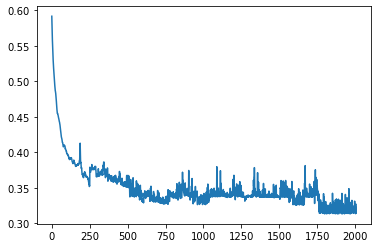

In [66]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

<AxesSubplot:>

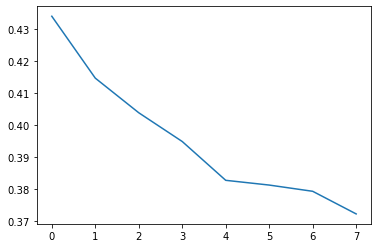

In [67]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses_test] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [68]:
data_test = []
for i in range(len(test_data)):
  data_test.append(data[test_data[i]])

In [69]:
data_test = tuple(data_test)

In [70]:
len(data_test)

16262

## Model Selection and results on test data

In [87]:
filename = "model7.pth"
classification_model = NeuralNet(data[0][0].shape[0],150)
classification_model.load_state_dict(torch.load(filename))
classification_model.eval()
classification_model.to(device)

NeuralNet(
  (fc1): Linear(in_features=36, out_features=150, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=150, out_features=2, bias=True)
)

In [88]:
test_loader = DataLoader(data_test,batch_size=len(data_test), shuffle=True)
dffull = pd.DataFrame(columns = ['y_real','y_pred'])
with torch.no_grad():
    for test_batch in test_loader : 
      test_batch[0] = test_batch[0].to(device)
      test_batch[1] = test_batch[1].to(device)
      pred = classification_model(test_batch[0]) 
      pred_frac0 = pred[:,0]
      pred_frac1 = pred[:,1]
      if n_classes == 3 : 
        pred_frac2 = pred[:,2]
      pred = pred.argmax(dim=1)  
      dftt = pd.DataFrame()
      dftt["y_real"] = test_batch[1].tolist()
      dftt["y_pred"] = pred.tolist()
      dftt["y_predfrac0"] = pred_frac0.tolist()
      dftt["y_predfrac1"] = pred_frac1.tolist()
      if n_classes == 3 : 
        dftt["y_predfrac2"] = pred_frac2.tolist()
      dffull = dffull.append(dftt)
      print(f1_score(dftt['y_real'], dftt['y_pred'],average='macro'))

dffull.to_csv('tt.csv')
dffull.tail()

0.9108090103404491


,y_real,y_pred,y_predfrac0,y_predfrac1
16257,0,0,1.000000e+00,3.628562e-17
16258,1,1,1.416704e-08,1.000000e+00
16259,1,1,1.772996e-05,9.999822e-01
16260,0,0,1.000000e+00,1.547428e-33
16261,0,0,1.000000e+00,4.203895e-45


F1_score(macro) :  0.9108090103404491
F1_score(micro) :  0.910835075636453
Accuracy :  0.910835075636453
Confusion Matrix : 


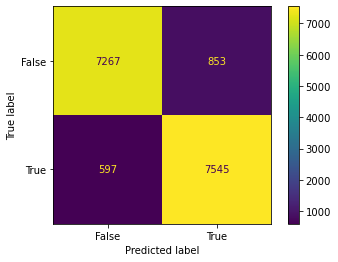

In [89]:
datahead = pd.read_csv('tt.csv')

print("F1_score(macro) : ", f1_score(datahead['y_real'], datahead['y_pred'],average='macro'))
print("F1_score(micro) : ", f1_score(datahead['y_real'], datahead['y_pred'],average='micro'))
print("Accuracy : ", accuracy_score(datahead['y_real'], datahead['y_pred']))
print("Confusion Matrix : ")
confusion_mat = confusion_matrix(datahead['y_real'], datahead['y_pred'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])
cm_display.plot()

In [90]:
dfttt = datahead.iloc[:,3:]
dfttt.head()

,y_predfrac0,y_predfrac1
0,0.999667,3.328555e-04
1,0.000166,9.998337e-01
2,0.000768,9.992317e-01
3,0.000761,9.992393e-01
4,1.000000,2.292606e-30


In [91]:
probab = dfttt.to_numpy()

In [ ]:
if n_classes==3 : 
  macro_roc_auc_ovo = roc_auc_score(datahead['y_real'],probab, multi_class="ovo", average="macro")
  print(macro_roc_auc_ovo)
  macro_roc_auc_ovo = roc_auc_score(datahead['y_real'],probab, multi_class="ovr", average="weighted")
  print(macro_roc_auc_ovo)
else : 
  auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
  print('AUC: %.3f' % auc)

In [ ]:
if n_classes == 3 : 
  Y_test = datahead['y_real']
  y_score = probab
  # Use label_binarize to be multi-label like settings
  Y = label_binarize(Y_test, classes=[0, 1, 2])
  n_classes = Y.shape[1]

  Y_test = Y


  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(
      Y_test.ravel(), y_score.ravel()
  )
  average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")
  average_precision["macro"] = average_precision_score(Y_test, y_score, average="macro")
  print(average_precision["micro"])
  print(average_precision["macro"])

In [ ]:
if n_classes == 3 :
  display = PrecisionRecallDisplay(
      recall=recall["micro"],
      precision=precision["micro"],
      average_precision=average_precision["micro"],
  )
  display.plot()
  _ = display.ax_.set_title("Micro-averaged over all classes")

Model: ROC AUC=0.951


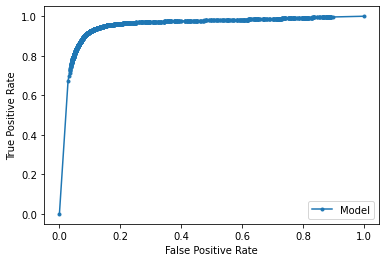

In [92]:
lr_auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
# summarize scores

print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, _ = roc_curve(datahead['y_real'],datahead['y_predfrac1'])
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.912 auc=0.954


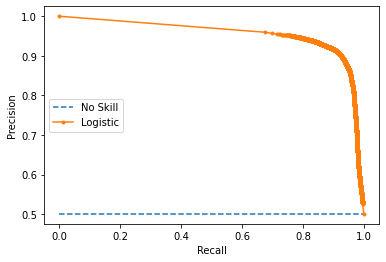

In [93]:
lr_precision, lr_recall, _ = precision_recall_curve(datahead['y_real'],datahead['y_predfrac1'])
lr_f1, lr_auc = f1_score(datahead['y_real'], datahead['y_pred']), metrics.auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(datahead['y_real'][datahead['y_real']==1]) / len(datahead['y_real'])
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [94]:
precision, recall, thresholds  = precision_recall_curve(datahead['y_real'], datahead['y_predfrac1'])
auc_score = metrics.auc(recall, precision)
auc_score

0.9537734332948103